# Notebook for performing evaluation on the search engine results

## Running the below code blocks will require up to 6GB of free RAM for the word encodings

In [1]:
# Imports
import gensim.downloader as api
import numpy as np
import search_engine as se
from nltk.tokenize import word_tokenize
import nltk.translate.bleu_score as bleu_score
from scipy import spatial
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
# Resource setup
sfunction = bleu_score.SmoothingFunction()

print("Loading word encodings...")
w2v = api.load("word2vec-google-news-300")

# Initialize the search engine class
print("Initializing search engine(s)...")
coco_clip = se.SearchEngine('coco_dataset')
# unsplash_clip = se.SearchEngine('unsplash_dataset')

print("Setup completed")

Loading word encodings...
Initializing search engine(s)...
Setup completed


In [3]:
with open("eval_data/queries.json") as query_file:
    query_categories = json.load(query_file)
category_keys = query_categories.keys()
category_titles = ["Technology", "Food and Beverages", "People and Activities", "Nature", "Arts and Crafts", "Pets and Animals", "Travel Destinations"]

In [4]:
# cat_count   =  7   # Total number of categories
# cat_queries = 10   # Number of queries per categories
# image_count = 50   # Number of images per query
# image_dist  = 20   # Distance between image for broader sampling spectrum

model_words = w2v.index_to_key

# Convert the queries to the corresponding indices from word2wec
# Work around the case-sensitive dataset and discard all non-existent words
def query_to_indices(query):
    idx_query = np.zeros(300)
    for word in query:
        lword = word.lower()
        uword = word.upper()
        if lword in model_words:
            idx_query += w2v[lword]
        elif uword in model_words:
            idx_query += w2v[uword]
    return idx_query

# Calculate the relevance for all images for all queries
def get_image_scores(eval_measures, clip_measure="cosine", n_images=50, query_indices=range(10), category_names=category_keys, image_dist=1):

    # Ensure image distance is not less than 1
    image_dist   = max(1, image_dist)

    n_queries    = len(query_indices)
    n_categories = len(category_names)

    bleu_scores = np.zeros((n_categories, n_queries, n_images))   # Bleu-scores
    cos_scores  = np.zeros((n_categories, n_queries, n_images))   # Cosine scores based on w2v+scipy
    wmd_scores  = np.zeros((n_categories, n_queries, n_images))   # Word mover distance scores based on w2v

    for ci, category in enumerate(category_names):
        for qi in tqdm(query_indices):
            query = query_categories[category][qi]

            # Choose image indices that are spaced apart, so we get a better idea of the general relevance trend
            indices = [idx*image_dist for idx in list(range(n_images))]
            descriptions = coco_clip.search(query, n_images*(image_dist + 1), return_url=False, comparison_func=clip_measure)
            filtered_descriptions = [descriptions[idx] for idx in indices]
            s_query = word_tokenize(query)

            # Calculate the similarity between the query and engine result for all measures
            for di, description in enumerate(filtered_descriptions):
                s_description = word_tokenize(description)
                if "bleu" in eval_measures: bleu_scores[ci][qi][di] = bleu_score.sentence_bleu([s_query], s_description, smoothing_function=sfunction.method4)
                if "cos"  in eval_measures: cos_scores[ci][qi][di]  = spatial.distance.cosine(query_to_indices(s_query), query_to_indices(s_description))
                if "wmd"  in eval_measures: wmd_scores[ci][qi][di]  = w2v.wmdistance(s_query, s_description)

    result_set = []
    if "bleu" in eval_measures: result_set.append(bleu_scores)
    if "cos"  in eval_measures: result_set.append(cos_scores)
    if "wmd"  in eval_measures: result_set.append(wmd_scores)

    return result_set


In [5]:
# Evaluation of the rank average results per category
[bleu_scores, cos_scores, wmd_scores] = get_image_scores(eval_measures=["bleu", "cos", "wmd"], clip_measure="cosine", image_dist=20, n_images=50)

100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


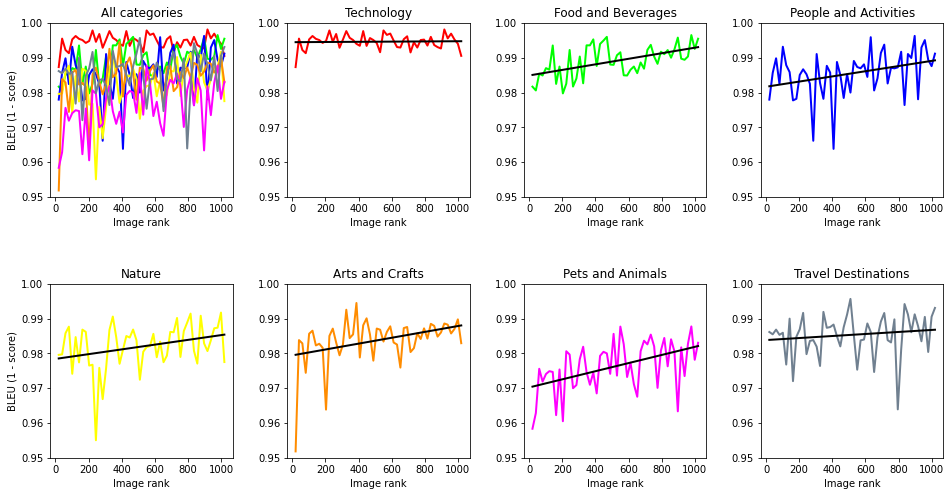

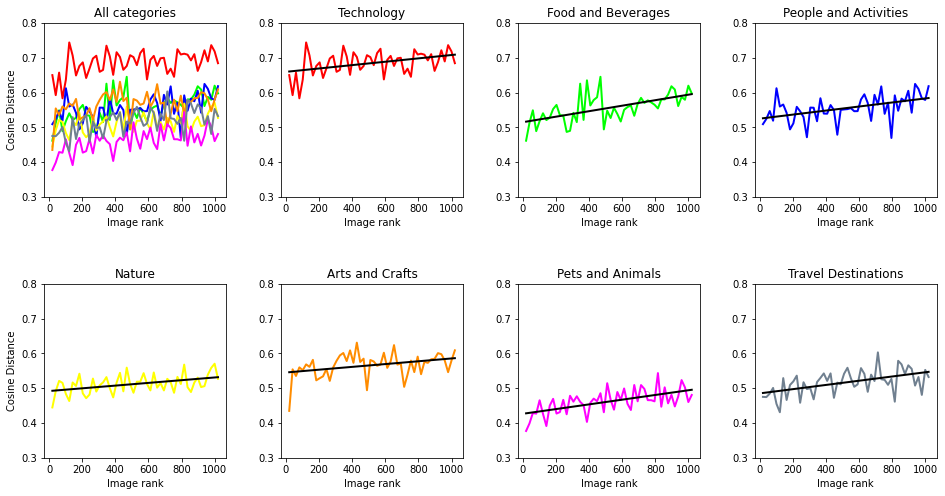

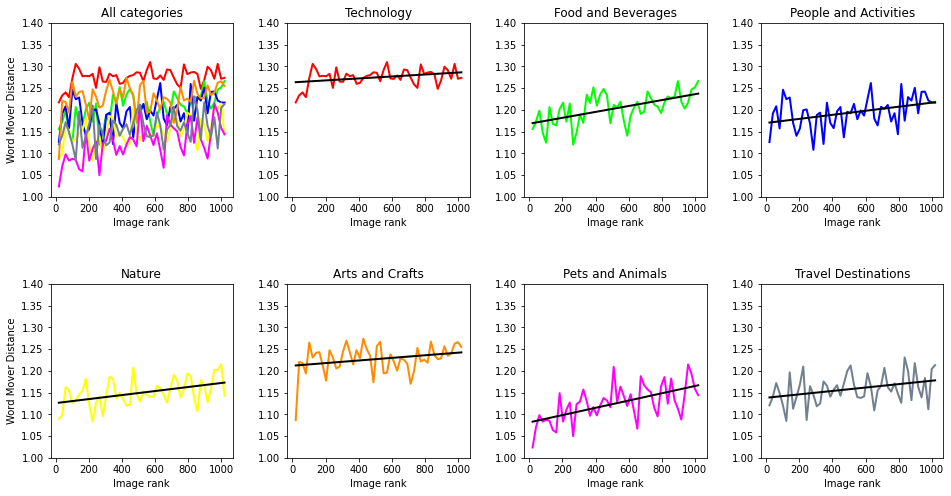

In [28]:
# Plotting for the results, adjust based on the individual request
color_list  = ["red", "lime", "blue", "yellow", "darkorange", "magenta", "slategray"]
measures  = {"BLEU": bleu_scores, "Cosine Distance": cos_scores, "Word Mover Distance": wmd_scores}

# Y-limits adjusted for our results to enable the best visualization
y_limits    = [[0.95, 1], [0.3,0.8], [1,1.4]]

x = np.multiply(np.linspace(1, 51, 50), 20)

# Correct measurements in case of Bleu, since those results are reversed
for mi, (name, measure) in enumerate(measures.items()):
    if name == "BLEU":
        average_ranks = np.subtract(1, np.average(measure, axis=1))
        name = "BLEU (1 - score)"
    else:
        average_ranks = np.average(measure, axis=1)

    # Create the base plot
    fig, axs = plt.subplots(2, 4)
    fig.set_size_inches(16, 8)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    axs[0][0].set_xlabel("Image rank")
    axs[0][0].set_ylabel(name)
    axs[1][0].set_ylabel(name)
    axs[0][0].set_ylim(y_limits[mi])
    axs[0][0].set_title(f"All categories")

    for i in list(range(7)):
        # Calculate Trend line
        fit = np.polyfit(x, average_ranks[i], 1)
        trend = np.poly1d(fit)

        # Create all relevant data for the plots
        axs[0][0].plot(x, average_ranks[i], linewidth=2, color=color_list[i])
        axs[(i+1) // 4][(i+1) % 4].plot(x, average_ranks[i], linewidth=2, color=color_list[i])
        axs[(i+1) // 4][(i+1) % 4].set_xlabel("Image rank")
        axs[(i+1) // 4][(i+1) % 4].plot(x, trend(x), linewidth=2, color="black")
        axs[(i+1) // 4][(i+1) % 4].set_title(f"{category_titles[i]}")
        axs[(i+1) // 4][(i+1) % 4].set_ylim(y_limits[mi])
    plt.show()

In [10]:
[cos_scores_short] = get_image_scores(eval_measures=["cos"], clip_measure="cosine", image_dist=1, n_images=10)

100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


In [27]:
query_averages = np.average(cos_scores_short, axis=2)
q_min = np.min(query_averages)
q_max = np.max(query_averages)
min_index = np.where(query_averages==q_min)
max_index = np.where(query_averages==q_max)

print(f"Best query: Query {min_index[1][0]} in {category_titles[min_index[0][0]]}")
print(f"Worst query: Query {max_index[1][0]} in {category_titles[max_index[0][0]]}")

Best query: Query 5 in Pets and Animals
Worst query: Query 9 in Nature
